In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

In [2]:
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Import and separate input vs target

In [4]:
# Identify the input columns (a list of column names - not including ID or Sale Price)
input_cols = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']
# Identify the name of the target column (a single string, not a list)
target_col = 'SalePrice'

In [5]:
#make a copy of input - keep your notebook clean
inputs = data[input_cols].copy()
targets = data[target_col]

In [6]:
categorical_cols = [var for var in data.columns if data[var].dtype == 'O']
numerical_cols = [var for var in data.columns if var not in categorical_cols and var != 'SalePrice']

vars_missing = [var for var in data.columns if data[var].isnull().sum() > 0]

categorical_na = [var for var in categorical_cols if var in vars_missing]
numerical_na = [var for var in numerical_cols if var in vars_missing]

print('Number of categorical variables with NA: ', len(categorical_na))
print('Number of numerical variables with NA: ', len(numerical_na))

Number of categorical variables with NA:  16
Number of numerical variables with NA:  3


In [7]:
print(len(categorical_cols))
print(len(numerical_cols))

43
37


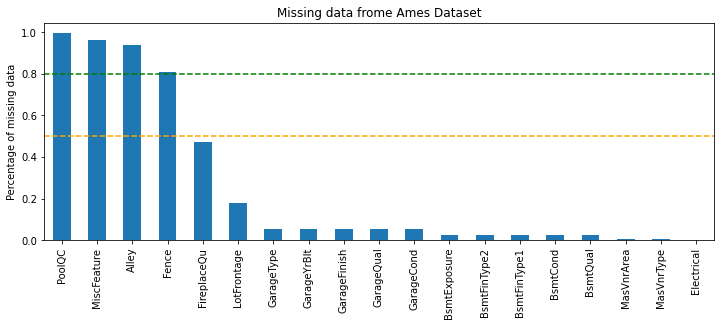

In [8]:
data[vars_missing].isnull().mean().sort_values(ascending = False).plot.bar(figsize = (12,4))
plt.ylabel('Percentage of missing data')
plt.title('Missing data frome Ames Dataset')
plt.axhline(0.8, color = 'green', linestyle = '--')
plt.axhline(0.5, color = 'orange', linestyle = '--')

# Correlation Matrix

In [9]:
#avoid a crowded correlation matrix, we're just going to take these out.
cols_corr_out = [
    "Id",
    "OverallCond",
    "Fireplaces",
    "PoolArea",
    "MiscVal",
    "MoSold",
    "YrSold",
    "BsmtHalfBath",
    "BsmtFinSF2",
    "LowQualFinSF",
    "EnclosedPorch",
]

In [10]:
corr_mat = (data.loc[:, ~data.columns.isin(cols_corr_out)].select_dtypes(['int64', 'float64']).corr())

corr_mat[['SalePrice']].sort_values('SalePrice', ascending= False).style.format(precision = 3).background_gradient(cmap="Greys")

,SalePrice
SalePrice,1.000
OverallQual,0.791
GrLivArea,0.709
GarageCars,0.640
GarageArea,0.623
TotalBsmtSF,0.614
1stFlrSF,0.606
FullBath,0.561
TotRmsAbvGrd,0.534
YearBuilt,0.523


Top 10 highest correlation with Target Variable
* OverallQual, GrLivArea
* GarageCars, GarageArea, GarageYrBlt
* TotalBsmtSF, 1stFlrSF
* FullBath, TotRmsAbvGrd, YearBuilt, YearRemodAdd

**Hack: Right click on the heatmap and open the image to a new tab for zooming flexibility**

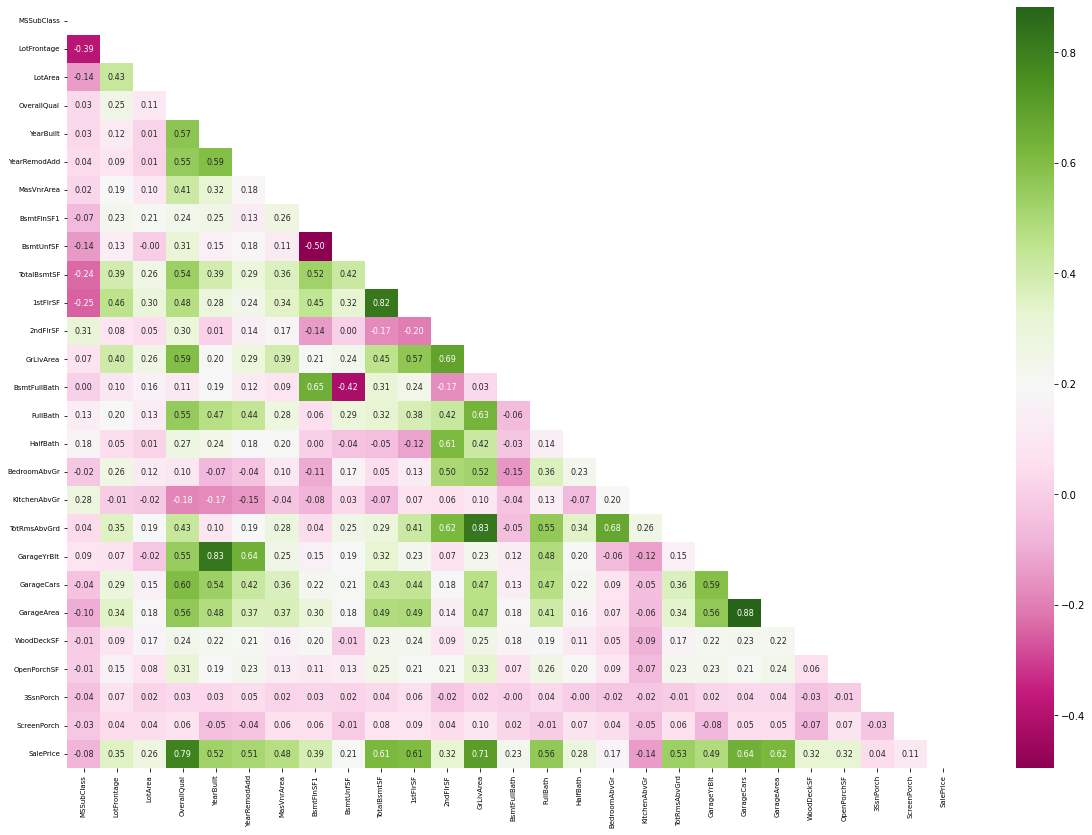

In [11]:
mask = np.triu(np.ones_like(corr_mat.corr()))
fig, ax = plt.subplots(figsize = (20, 14))
sns.heatmap(corr_mat, mask = mask, 
            annot = True, annot_kws = {'size':8}, fmt=".2f", 
           cmap="PiYG")
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)
plt.show()


Observations:

OK! this Matrix has a lot of information to give, many variables are correlated together, and most of them are practically obvious to be correlated such like:

* "1stFlSf" and "TotalBsmtSF": 0.82

* "TotalRmsAbvGrd" and "GrLivArea": 0.83

* "GarageArea" and "GarageCars": 0.88

* "GrLivArea" and "2ndFlrSF": 0.69

* "TotalRmsAbvGrd" and "BedroomAbvGr": 0.68

* "BsmtFullBath" and "BsmtFinSF1": 0.65

* "FullBath" and "GrLivArea": 0.63

* "YearBuilt" and "OverallQual": 0.57

* "YearRemodAdd" and "YearBuilt": 0.59

* "FullBath" and "YearBuilt": 0.59

It is a very informative Matrix, if we going to build a model, in any way let's move to Feature-Engineering section to see how we're going to manage it!

In [12]:
#correlation cell for quick and close looks at specific variable relationships
corrquickview = ['MSSubClass', 'LotFrontage', 
                 'SalePrice', 'MasVnrArea']
data[corrquickview].corr()

,MSSubClass,LotFrontage,SalePrice,MasVnrArea
MSSubClass,1.000000,-0.386347,-0.084284,0.022936
LotFrontage,-0.386347,1.000000,0.351799,0.193458
SalePrice,-0.084284,0.351799,1.000000,0.477493
MasVnrArea,0.022936,0.193458,0.477493,1.000000


In [13]:
#quick correlation of variables I removed earlier
cols_corr_out_r2 = [
    'Id', "OverallCond", "Fireplaces", "PoolArea", "MiscVal", "MoSold",
    "YrSold", "BsmtHalfBath", "BsmtFinSF2", "LowQualFinSF", "EnclosedPorch",
    'SalePrice' #add SalePrice into list.
]

In [14]:
corr_mat = (data[cols_corr_out_r2].select_dtypes(['int64', 'float64']).corr())

corr_mat[['SalePrice']].sort_values('SalePrice', ascending= False).style.format(precision = 3).background_gradient(cmap="Greys")

,SalePrice
SalePrice,1.000
Fireplaces,0.467
PoolArea,0.092
MoSold,0.046
BsmtFinSF2,-0.011
BsmtHalfBath,-0.017
MiscVal,-0.021
Id,-0.022
LowQualFinSF,-0.026
YrSold,-0.029


# Deleting Variables - prepping for modeling

Reasoning will be in medium blog post

**Training data first**

In [15]:
dropcolumns = [ #about 50% missing
                'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                #all Garage Features except GarageCars
                'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea',
                #all Basement Features except TotalBsmtSF
                'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'BsmtHalfBath',
                'BsmtFullBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                #Masonry Vaneer Features
                'MasVnrArea', 'MasVnrType',
                #Other
                'LotFrontage', '1stFlrSF', 'TotRmsAbvGrd',
                #Irrelevant
                'Id', 'PoolArea', 'MoSold', 'MiscVal', 'LowQualFinSF', 'YrSold']
train = data.drop(dropcolumns, axis = 1)
#fill in single missing electrical variables. 
train.Electrical.fillna(train.Electrical.mode, inplace = True)

#check if any missing values in each dataset
print('Missing values in train dataset: ', train.isnull().values.sum())

Missing values in train dataset:  0


In [16]:
categorical_cols = [var for var in train.columns if train[var].dtype == 'O']
numerical_cols = [var for var in train.columns if var not in categorical_cols and var != 'SalePrice']

print('After removing variables in the our training exercise above, we now have \n',
     len(categorical_cols), "categorical variables and \n",
     len(numerical_cols), "numerical variables excluding the target variable - SalePrice.")

After removing variables in the our training exercise above, we now have 
 28 categorical variables and 
 20 numerical variables excluding the target variable - SalePrice.


**Prep test data and ensure no missing variables**

In [17]:
test = test.drop(dropcolumns, axis = 1)
test.Electrical.fillna(test.Electrical.mode, inplace = True)
print('Missing values in test dataset: ', test.isnull().values.sum())

Missing values in test dataset:  14


Text(0.5, 1.0, 'Missing data frome Ames Test Dataset')

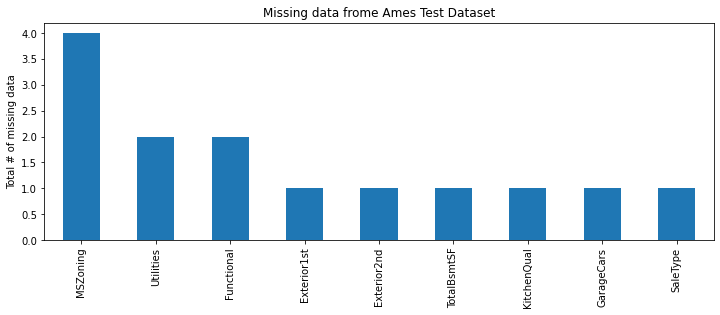

In [18]:
test_vars_missing = [var for var in test.columns if test[var].isnull().sum() > 0]
test[test_vars_missing].isnull().sum().sort_values(ascending = False).plot.bar(figsize = (12,4))
plt.ylabel('Total # of missing data')
plt.title('Missing data frome Ames Test Dataset')

In [20]:
#fill in missing columns with mode of test dataset
for test_var in test_vars_missing:
    test[test_var].fillna(test[test_var].mode, inplace = True)

print("Updated Test Data missing values",  test.isnull().values.sum())

Updated Test Data missing values 0


# Feature Engineering

A quick look into possible feature engineering

In [21]:
data['Total_sqft'] = data['GrLivArea'] + data['TotalBsmtSF']
data['Total_bathrooms'] = data['FullBath'] + data['HalfBath'] + data['BsmtFullBath'] + data['BsmtHalfBath']
data['House_Age'] = data['YrSold'] - data['YearBuilt']
data['House_age_remod'] = data['YrSold'] - data['YearRemodAdd']